In [1]:
!pip install gurobipy
!pip install yfinance


In [12]:
import gurobipy as gp
from gurobipy import GRB
import yfinance as yf
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

For this portfolio we'll be using the top 20 companies in the U.S. by Market cap. However it can be adapted to a multitude of stocks depending on how you want to structure your portfolio. 

In [3]:
stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'BRK-B', 'TSLA', 'LLY', 'V', 'UNH', 'JPM', 'XOM', 'WMT', 'AVGO', 'MA', 'JNJ', 'PG', 'ORCL', 'HD']

In [4]:
#using 5 years to try and get pre-covid performance. when I've run this with 2 years the volatility spikes. again use a timeframe for your portfolio to show where you think we're going
data = yf.download(stocks, period='5y')

[*********************100%%**********************]  20 of 20 completed


In [5]:
closes=np.transpose(np.array(data.Close))
absdiff = np.diff(closes)
reldiff = np.divide(absdiff, closes[:,:-1])
delta = np.mean(reldiff, axis=1)
sigma = np.cov(reldiff)
std = np.std(reldiff,axis=1)

In [6]:
m=gp.Model('portfolio')
x=m.addMVar(len(stocks))
portfolio_risk=x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

m.addConstr(x.sum()==1,'budget') 
m.optimize()

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0x4a727a1e
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.03s
Presolved: 1 rows, 20 columns, 20 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 1.900e+02
 Factor NZ  : 2.100e+02
 Factor Ops : 2.870e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal  

In [7]:
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=stocks+['Volatility','Expected Return'],
             columns = ['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
AAPL,4.276466e-07
MSFT,4.434265e-02
GOOG,1.500155e-06
AMZN,1.334144e-01
NVDA,1.583782e-05
META,1.345770e-06
BRK-B,3.050506e-01
TSLA,6.447158e-07
LLY,2.219645e-02
V,4.701276e-07


Here we have the allocations for our portfolio. the volatility is a variance so we need to take the square root to get the standard deviation which we'll do below. and we can take expected return x250(trading days in a year) to get expected return. (past performance obviously isn't always an indicator of future performance)

In [8]:
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 20):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x441162f8
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-04, 3e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 1e+00]
Presolve time: 0.04s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.15252284e+05 -2.15252284e+05  1.55e

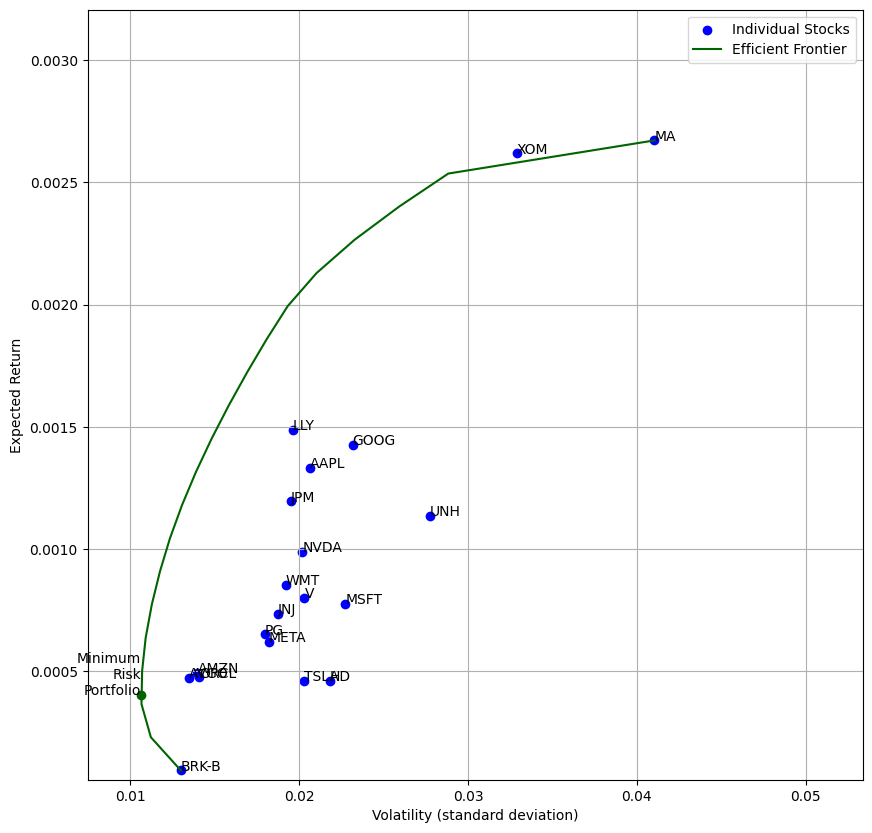

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=std, y=delta,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]))
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')
ax.set_xlim(frontier[0].min()*0.7, frontier[0].max()*1.3)
ax.set_ylim(delta.min()*.6, delta.max()*1.2)
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()

Plotted out volatility on the X-Axis, Expected returns on the Y-Axis. Mastercard and Exxon both have the highest returns with the most volatility, this is expected for an oil company who is naturally volatile with shareprice often correlated to oil price, and the war in Ukrain and Israel Palestine conflict causing oil prices to trend up has been very helpful for Exxon. Mastercard continues to beat their industry average growing earnings at 12% while the Financial industry average is about 7.8%. However because this is a minimum risk portfolio based on [the Markowitz model](https://en.wikipedia.org/wiki/Markowitz_model) Exxon and Mastercard make up a small percentage of the portfolio due to their high volatility (.00002%, and .3% respectively). We are looking to minimize volatility while maximizing risk. Thus BRK.B makes up the largest portion of our portfolio at 30%, known for being the slow but steady type of return, followed by Oracle at 25.7% and Broadcomm at 17.9%.